HSE, Applied Time Series Forecasitng , Winter 2022-23

<font color="blue"> HW #3 </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

<h1 align="center">Organization Info</h1>

**Оформление дз**:
- Присылайте выполненное задание в гугл-форму: https://forms.gle/Jafoe52VmyraPbgP7
- Выполненное дз сохраните в файл Surname_w2022_23_hw3.ipynb, например, ivanov_w2022_23_hw3.ipynb

**Вопросы**:
- Присылайте вопросы в телеграм чат

**Deadilne**: <font color="red"> 31-Jan-2023 11:59:59 pm CET </font>

В случае присланного решения позже дедлайна максимальный бал буде снижен согласно формуле

$$МаксимальныйБалл=\max\bigl(3,max(0,(10-ДнейПослеДедлайна/7))) \bigr).$$
График зависимости максимально возможного балла за ДЗ от просрочки дедлайна приведён ниже:

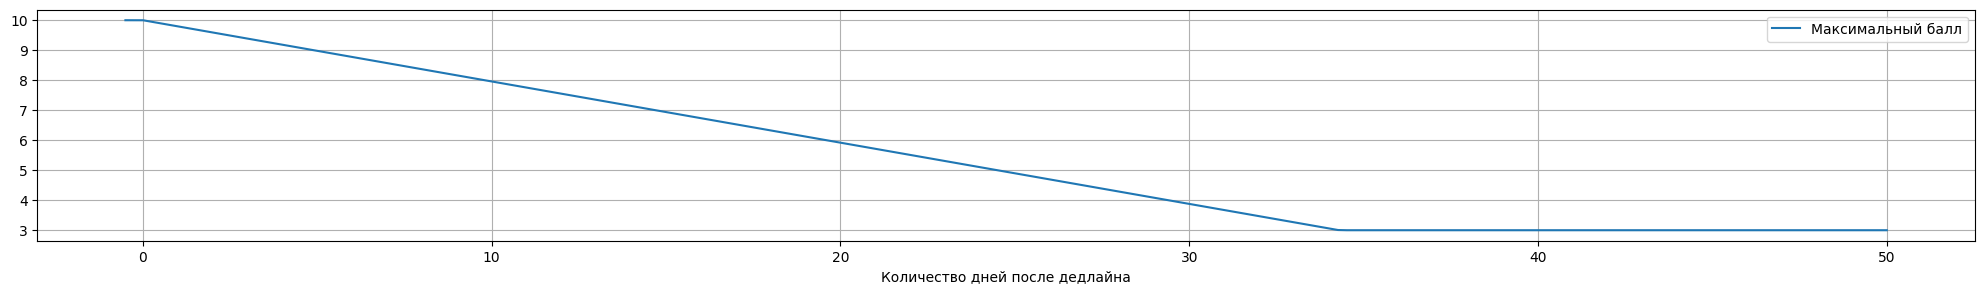

In [1]:
import pandas as pd
import numpy as np
a = 2
ax = pd.DataFrame(data = [[x, min(10, 10*max(0.3, (1-x/49)))] for x in np.linspace(-0.5,50,200)], columns = ['Количество дней после дедлайна', 'Максимальный балл']).set_index('Количество дней после дедлайна').plot(figsize = (25,3), grid = True)

<h1 align="center"> Kaggle contest (100%)</h1>

  
* Participate in kaggle contest https://www.kaggle.com/t/9552921f2eee4dada08dc692defef899

* it is allowed to use any python or R packages
* 2 benchmarks:
  - you'll get $mark \in (6, 8]$ of 10 if your approach outperforms benchmark1
  - you'll get $mark\in (8,10]$ of 10 if your approach outperforms benchmark2
  - final $mark$ will be derived based on leaderboard
  - you have to send code with the final solution to the google form https://forms.gle/Jafoe52VmyraPbgP7 (otherwise final mark will be 0)


# Импотры инсталлы и тп

In [2]:
!pip install window-ops
!pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.5 MB/s eta 0:00:00


In [3]:
from pathlib import Path

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
# from mlforecast import Forecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import seasonal_rolling_mean, rolling_mean

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# from utils import qualityWAPE, qualityRMSE
import warnings, pylab

import itertools
import datetime
import matplotlib.dates as mdates
from cycler import cycler

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display

# Модель со скором 79.79. Ф-ии генерации фичей скопипащенны из семинара \ гитхаба

In [4]:
df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('test_kaggle.csv')
sub = pd.read_csv('submission_sample.csv')
df = pd.concat([df_train, df_test.drop('id', axis=1)], axis=0, ignore_index=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index(['Date'], inplace=True)
df['Promo'] = df['Promo'].fillna(0)
df.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
df['Regular_Price'] = df['Regular_Price'].ffill().bfill()
df.reset_index().set_index(['Date'], inplace=True)

In [6]:
df['Actual_Price'] = df['Promo_Price'].combine_first(df['Regular_Price'])
df['Promo_percent'] = (1 - (df['Actual_Price'] / df['Regular_Price']))
df = df.drop('Promo_Price', axis=1)

df.reset_index(inplace=True)
df["weekday"] = df['Date'].dt.weekday
df["monthday"] = df['Date'].dt.day
df['is_weekend'] = df['weekday'].isin([5, 6]) * 1
df['month_period'] = 0
df.loc[df['monthday'] >= 15, 'month_period'] = 1

df['demand_expanding_mean'] = df.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])

In [7]:
from scipy.signal import cwt, find_peaks_cwt, ricker, welch

def _get_length_sequences_where(x):
    """
    This method calculates the length of all sub-sequences where the array x is either True or 1.
    Examples
    --------
    >>> x = [0,1,0,0,1,1,1,0,0,1,0,1,1]
    >>> _get_length_sequences_where(x)
    >>> [1, 3, 1, 2]
    >>> x = [0,True,0,0,True,True,True,0,0,True,0,True,True]
    >>> _get_length_sequences_where(x)
    >>> [1, 3, 1, 2]
    >>> x = [0,True,0,0,1,True,1,0,0,True,0,1,True]
    >>> _get_length_sequences_where(x)
    >>> [1, 3, 1, 2]
    :param x: An iterable containing only 1, True, 0 and False values
    :return: A list with the length of all sub-sequences where the array is either True or False. If no ones or Trues
    contained, the list [0] is returned.
    """
    if len(x) == 0:
        return [0]
    else:
        res = [len(list(group)) for value, group in itertools.groupby(x) if value == 1]
        return res if len(res) > 0 else [0]


def percentile(n):
    """
    Calculate n - percentile of data
    """
    def percentile_(x):
        return np.nanpercentile(x, n)

    percentile_.__name__ = 'perc%s' % n
    return percentile_


def variation(x):
    """
    Returns the variation coefficient (standard error / mean, give relative value of variation around mean) of x.
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    mean = x.mean()
    if mean != 0:
        return x.std() / mean
    else:
        return np.nan

def abs_energy(x):
    """
    Returns the absolute energy of the time series which is the sum over the squared values
    .. math::
        E = \\sum_{i=1,\\ldots, n} x_i^2
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.nansum(x * x)

def absolute_sum_of_changes(x):
    """
    Returns the sum over the absolute value of consecutive changes in the series x
    .. math::
        \\sum_{i=1, \\ldots, n-1} \\mid x_{i+1}- x_i \\mid
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.nansum(np.abs(np.diff(x)))

def count_above_mean(x):
    """
    Returns the number of values in x that are higher than the mean of x
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = x.mean()
    return np.where(x > m)[0].size

def count_below_mean(x):
    """
    Returns the number of values in x that are lower than the mean of x
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = x.mean()
    return np.where(x < m)[0].size


def count_above(t):
    """
    Returns the percentage of values in x that are higher than t
    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param t: value used as threshold
    :type t: float
    :return: the value of this feature
    :return type: float
    """
    def count_above_(x):
        return np.sum(x >= t) / len(x)

    count_above_.__name__ = 'count_above%s' % t
    return count_above_

def count_below(t):
    """
    Returns the percentage of values in x that are lower than t
    :param x: the time series to calculate the feature of
    :type x: pandas.Series
    :param t: value used as threshold
    :type t: float
    :return: the value of this feature
    :return type: float
    """
    def count_below_(x):
        return np.sum(x <= t) / len(x)

    count_above_.__name__ = 'count_above%s' % t
    return count_above_mean

def first_location_of_minimum(x):
    """
    Returns the first location of the minimal value of x.
    The position is calculated relatively to the length of x.
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.argmin(x) / len(x) if len(x) > 0 else np.NaN

def first_location_of_maximum(x):
    """
    Returns the first location of the maximum value of x.
    The position is calculated relatively to the length of x.
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.argmax(x) / len(x) if len(x) > 0 else np.NaN


def longest_strike_below_mean(x):
    """
    Returns the length of the longest consecutive subsequence in x that is smaller than the mean of x
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.max(_get_length_sequences_where(x < x.mean())) if x.size > 0 else 0

def longest_strike_above_mean(x):
    """
    Returns the length of the longest consecutive subsequence in x that is bigger than the mean of x
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.max(_get_length_sequences_where(x > x.mean())) if x.size > 0 else 0


def mean_second_derivative_central(x):
    """
    Returns the mean value of a central approximation of the second derivative
    .. math::
        \\frac{1}{2(n-2)} \\sum_{i=1,\\ldots, n-1}  \\frac{1}{2} (x_{i+2} - 2 \\cdot x_{i+1} + x_i)
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return (x[-1] - x[-2] - x[1] + x[0]) / (2 * (len(x) - 2)) if len(x) > 2 else np.NaN

def number_crossing_m(x):
    """
    Calculates the number of crossings of x on m. A crossing is defined as two sequential values where the first value
    is lower than mean and the next is greater, or vice-versa.
    crossings.
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: int
    """
    m = x.mean()
    positive = x > m
    return np.where(np.diff(positive))[0].size

def number_cwt_peaks(n):
    """
    Number of different peaks in x.
    To estimamte the numbers of peaks, x is smoothed by a ricker wavelet for widths ranging from 1 to n. This feature
    calculator returns the number of peaks that occur at enough width scales and with sufficiently high
    Signal-to-Noise-Ratio (SNR)
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :param n: maximum width to consider
    :type n: int
    :return: the value of this feature
    :return type: int
    """
    def number_cwt_peaks_(x):

        return len(
            find_peaks_cwt(vector=x, widths=np.array(list(range(1, n + 1))), wavelet=ricker)
        )

    return number_cwt_peaks_

def range_count(x):
    """
    Count observed values within the interval [mean - 3*std, max + 3*std).
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the count of values within the range
    :rtype: int
    """
    min_ = x.mean() - 3 * x.std()
    max_ = x.mean() + 3 * x.std()
    return np.sum((x >= min_) & (x < max_))


def ratio_beyond_r_sigma(r):
    """
    Ratio of values that are more than r * std(x) (so r times sigma) away from the mean of x.
    :param x: the time series to calculate the feature of
    :type x: iterable
    :param r: the ratio to compare with
    :type r: float
    :return: the value of this feature
    :return type: float
    """
    def ratio_beyond_r_sigma_(x):
        return np.sum(np.abs(x - x.mean()) > r * x.std()) / x.size

    return ratio_beyond_r_sigma_

def root_mean_square(x):
    """
    Returns the root mean square (rms) of the time series.
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    return np.sqrt(np.square(x).mean()) if len(x) > 0 else np.NaN

def symmetry_looking(r):
    """
    Boolean variable denoting if the distribution of x *looks symmetric*. This is the case if
    .. math::
        | mean(X)-median(X)| < r * (max(X)-min(X))
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :r: is the percentage of the range to compare with
    :type r: float
    :return: the value of this feature
    :return type: bool
    """
    def symmetry_looking_(x):
        mean_median_difference = np.abs(x.mean() - x.median())
        max_min_difference = x.max() - x.min()
        return mean_median_difference < (r * max_min_difference)

    return symmetry_looking_

def benford_correlation(x):
    """
     Useful for anomaly detection applications [1][2]. Returns the correlation from first digit distribution when
     compared to the Newcomb-Benford's Law distribution [3][4].
     .. math::
         P(d)=\\log_{10}\\left(1+\\frac{1}{d}\\right)
     where :math:`P(d)` is the Newcomb-Benford distribution for :math:`d` that is the leading digit of the number
     {1, 2, 3, 4, 5, 6, 7, 8, 9}.
     .. rubric:: References
     |  [1] A Statistical Derivation of the Significant-Digit Law, Theodore P. Hill, Statistical Science, 1995
     |  [2] The significant-digit phenomenon, Theodore P. Hill, The American Mathematical Monthly, 1995
     |  [3] The law of anomalous numbers, Frank Benford, Proceedings of the American philosophical society, 1938
     |  [4] Note on the frequency of use of the different digits in natural numbers, Simon Newcomb, American Journal of
     |  mathematics, 1881
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    x = np.array(
        [int(str(np.format_float_scientific(i))[:1]) for i in np.abs(np.nan_to_num(x))]
    )

    benford_distribution = np.array([np.log10(1 + 1 / n) for n in range(1, 10)])
    data_distribution = np.array([(x == n).mean() for n in range(1, 10)])

    return np.corrcoef(benford_distribution, data_distribution)[0, 1]

def cid_ce(x):
    """
    This function calculator is an estimate for a time series complexity [1] (A more complex time series has more peaks,
    valleys etc.). It calculates the value of
    .. math::
        \\sqrt{ \\sum_{i=1}^{n-1} ( x_{i} - x_{i-1})^2 }
    .. rubric:: References
    |  [1] Batista, Gustavo EAPA, et al (2014).
    |  CID: an efficient complexity-invariant distance for time series.
    |  Data Mining and Knowledge Discovery 28.3 (2014): 634-669.
    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    x = np.diff(x)
    return np.sqrt(np.nansum(x * x))

In [8]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')



import os
import sys
project_path = os.path.abspath(os.path.join('..'))

if project_path not in sys.path:
    sys.path.append(project_path)

def read_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

## add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:

    '''
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)

                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

In [9]:
df

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,weekday,monthday,is_weekend,month_period,demand_expanding_mean
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.0,3,1,0,0,22.000000
1,2015-01-02,1,1,0.0,41.0,163.78,163.78,0.0,4,2,0,0,31.500000
2,2015-01-03,1,1,0.0,35.0,163.78,163.78,0.0,5,3,1,0,32.666667
3,2015-01-04,1,1,0.0,72.0,163.78,163.78,0.0,6,4,1,0,42.500000
4,2015-01-05,1,1,0.0,25.0,163.78,163.78,0.0,0,5,0,0,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-15,110,2,0.0,NaN,133.06,133.06,0.0,2,15,0,1,NaN
92882,2016-06-16,110,2,0.0,NaN,133.06,133.06,0.0,3,16,0,1,NaN
92883,2016-06-17,110,2,0.0,NaN,133.06,133.06,0.0,4,17,0,1,NaN
92884,2016-06-18,110,2,0.0,NaN,133.06,133.06,0.0,5,18,1,1,NaN


In [10]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]

df['NoFilter'] = 1
data_lagged_features = generate_lagged_features(df
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [7, 14, 21, 28]
                    , windows = ['7D','14D', '28D', '56D']
                    , preagg_methods = ['sum']
                    , agg_methods = ['mean', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [7, 14, 28], 'Promo': [7, 14, 28]}
                    )

IntProgress(value=0, max=96)

In [11]:
test_start_dt = '2016-05-22'

data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc['2016-05-23':].head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,weekday,monthday,is_weekend,...,Demand_lag28d_w7D_keySKU_id_preagsum_agperc90_NoFilter_dynamic_rolling,Demand_lag28d_w14D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag28d_w14D_keySKU_id_preagsum_agperc10_NoFilter_dynamic_rolling,Demand_lag28d_w14D_keySKU_id_preagsum_agperc90_NoFilter_dynamic_rolling,Demand_lag28d_w28D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag28d_w28D_keySKU_id_preagsum_agperc10_NoFilter_dynamic_rolling,Demand_lag28d_w28D_keySKU_id_preagsum_agperc90_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agperc10_NoFilter_dynamic_rolling,Demand_lag28d_w56D_keySKU_id_preagsum_agperc90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-23,38,1,1.0,NaN,128.98,119.6,0.072724,0,23,0,...,132305.0,56923.5,15970.3,113931.5,35679.535714,13621.2,91575.6,34928.589286,13939.5,68088.0
2016-05-23,60,2,0.0,NaN,138.50,138.5,0.000000,0,23,0,...,8763.2,4056.5,293.9,8326.9,2196.607143,288.1,7790.0,1947.339286,292.5,7069.5
2016-05-23,59,2,0.0,NaN,138.50,138.5,0.000000,0,23,0,...,8763.2,4056.5,293.9,8326.9,2196.607143,288.1,7790.0,1947.339286,292.5,7069.5
2016-05-23,69,2,0.0,NaN,138.50,138.5,0.000000,0,23,0,...,8763.2,4056.5,293.9,8326.9,2196.607143,288.1,7790.0,1947.339286,292.5,7069.5
2016-05-23,37,1,1.0,NaN,128.98,119.6,0.072724,0,23,0,...,132305.0,56923.5,15970.3,113931.5,35679.535714,13621.2,91575.6,34928.589286,13939.5,68088.0


In [12]:
# train specific model for each SKU
data_lagged_features['weekday'] = data_lagged_features['weekday'].astype(int)
data_lagged_features['monthday'] = data_lagged_features['monthday'].astype(int)
data_lagged_features['is_weekend'] = data_lagged_features['is_weekend'].astype(int)

sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

In [13]:
predicts1 = []
predicts2 = []

for store in sorted(sku1_train['Store_id'].loc[:].unique()):
    if store not in sorted([101,102,103,107,108,109,110]):
      lgbm1 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm1.fit(X = sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt].Demand)
      pred_1 = lgbm1.predict(sku1_train[sku1_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts1.append(pred_1)

      lgbm2 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm2.fit(X = sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt].Demand)
      pred_2 = lgbm2.predict(sku2_train[sku2_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts2.append(pred_2)
    else:
      lgbm1_1 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm1_1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku1_train.loc[:test_start_dt].Demand)
      pred1_1 = lgbm1_1.predict(sku1_train[sku1_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts1.append(pred1_1)


      lgbm2_2 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm2_2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku2_train.loc[:test_start_dt].Demand)
      pred2_2 = lgbm2_2.predict(sku2_train[sku2_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts2.append(pred2_2)

joinedlist1 = list(itertools.chain.from_iterable(predicts1))
joinedlist2 = list(itertools.chain.from_iterable(predicts2))

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [14]:
final_list = joinedlist1 + joinedlist2
len(final_list)

5970

In [15]:
sub['Demand'] = final_list
sub.to_csv('sub111.csv', index=False)

# Модель со скором 68.2 и самописной ф-ией генерации фичей

In [19]:
# загружаем данные
df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('test_kaggle.csv')
sub = pd.read_csv('submission_sample.csv')
df = pd.concat([df_train, df_test.drop('id', axis=1)], axis=0, ignore_index=True)

In [5]:
df_train

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN
...,...,...,...,...,...,...,...
86911,106,2,18.05.2016,NaN,9,138.50,NaN
86912,106,2,19.05.2016,NaN,3,138.50,NaN
86913,106,2,20.05.2016,NaN,13,138.50,NaN
86914,106,2,21.05.2016,NaN,3,138.50,NaN


In [6]:
# преобразуем дату\цену
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index(['Date'], inplace=True)
df['Promo'] = df['Promo'].fillna(0)
df.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
df['Regular_Price'] = df['Regular_Price'].ffill().bfill()
df.reset_index().set_index(['Date'], inplace=True)

In [7]:
df

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,0.0,22.0,163.78,NaN
2015-01-02,1,1,0.0,41.0,163.78,NaN
2015-01-03,1,1,0.0,35.0,163.78,NaN
2015-01-04,1,1,0.0,72.0,163.78,NaN
2015-01-05,1,1,0.0,25.0,163.78,NaN
...,...,...,...,...,...,...
2016-06-15,110,2,0.0,NaN,133.06,NaN
2016-06-16,110,2,0.0,NaN,133.06,NaN
2016-06-17,110,2,0.0,NaN,133.06,NaN


In [8]:
# переписываем финальную цену и пара новых фичей
df['Actual_Price'] = df['Promo_Price'].combine_first(df['Regular_Price'])
df['Promo_percent'] = (1 - (df['Actual_Price'] / df['Regular_Price']))
df = df.drop('Promo_Price', axis=1)

df.reset_index(inplace=True)
df['demand_expanding_mean'] = df.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])


In [9]:
# генерим фичи
# создаем лаги\агрегации
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['Demand'].shift(lag)

    data['rolling_mean_{}'.format(lag)] = data['Demand'].shift().rolling(rolling_mean_size).mean()
    data['rolling_median_{}'.format(lag)] = data['Demand'].shift().rolling(rolling_mean_size).median()

# создаем фичи из даты
def roll_agg_lag_features(new_data):
  new_data["weekday"] = pd.to_numeric(new_data.Date.dt.weekday)
  new_data["monthday"] = pd.to_numeric(new_data.Date.dt.day)
  new_data['is_weekend'] = pd.to_numeric(new_data.weekday.isin([5,6])*1)

# поэтапно применяем генерацию фичей
  make_features(new_data, 7, 1)
  make_features(new_data, 7, 3)
  make_features(new_data, 14, 7)
  make_features(new_data, 31, 7)
  make_features(new_data, 41, 7)

  result = pd.DataFrame(columns = new_data.columns)

  for i in new_data['Store_id'].unique():
    frames = new_data[new_data['Store_id']==i]#[41:]
    result = pd.concat([result, frames])
  return result.reset_index(drop=True)

In [10]:
# генерация новых фичей на всем датасете
data_lagged_features = roll_agg_lag_features(df)
data_lagged_features

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,demand_expanding_mean,weekday,...,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,rolling_mean_41,rolling_median_41
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.0,22.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,1,1,0.0,41.0,163.78,163.78,0.0,31.500000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,1,1,0.0,35.0,163.78,163.78,0.0,32.666667,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,1,1,0.0,72.0,163.78,163.78,0.0,42.500000,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,1,1,0.0,25.0,163.78,163.78,0.0,39.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-15,110,2,0.0,NaN,133.06,133.06,0.0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92882,2016-06-16,110,2,0.0,NaN,133.06,133.06,0.0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92883,2016-06-17,110,2,0.0,NaN,133.06,133.06,0.0,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92884,2016-06-18,110,2,0.0,NaN,133.06,133.06,0.0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# определяем границу трейна-предикта, используем дату как индекс
test_start_dt = '2016-05-22'

data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc['2016-05-23':].head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,demand_expanding_mean,weekday,monthday,...,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,rolling_mean_41,rolling_median_41
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-23,1,1,1.0,NaN,128.98,119.60,0.072724,260.531496,0,23,...,31.0,9.0,6.0,3.0,9.0,3.0,16.0,6.0,4.857143,3.0
2016-05-24,1,1,0.0,NaN,128.98,128.98,0.000000,260.531496,1,24,...,57.0,31.0,9.0,6.0,3.0,9.0,3.0,16.0,NaN,NaN
2016-05-25,1,1,0.0,NaN,131.70,131.70,0.000000,260.531496,2,25,...,35.0,57.0,31.0,9.0,6.0,3.0,9.0,3.0,NaN,NaN
2016-05-26,1,1,0.0,NaN,131.70,131.70,0.000000,260.531496,3,26,...,38.0,35.0,57.0,31.0,9.0,6.0,3.0,9.0,NaN,NaN
2016-05-27,1,1,0.0,NaN,131.70,131.70,0.000000,260.531496,4,27,...,19.0,38.0,35.0,57.0,31.0,9.0,6.0,3.0,NaN,NaN


In [12]:
# преобразуем obj колонки в нужные
data_lagged_features['weekday'] = data_lagged_features['weekday'].astype(int)
data_lagged_features['monthday'] = data_lagged_features['monthday'].astype(int)
data_lagged_features['is_weekend'] = data_lagged_features['is_weekend'].astype(int)

# делим датасет по sku
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

In [ ]:
# обучаем 2 модели на каждый из sku, причем для каждого магазина свою модель
# отсутствующие в трейне магазины предсказываем вдумя моделями, обученными
# на каждый sku но на всех данных
predicts1 = []
predicts2 = []

for store in sorted(sku1_train['Store_id'].loc[:].unique()):
    if store not in sorted([101,102,103,107,108,109,110]):
      lgbm1 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm1.fit(X = sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt].Demand)
      pred_1 = lgbm1.predict(sku1_train[sku1_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts1.append(pred_1)

      lgbm2 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm2.fit(X = sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt].Demand)
      pred_2 = lgbm2.predict(sku2_train[sku2_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts2.append(pred_2)
    else:
      lgbm1_1 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm1_1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku1_train.loc[:test_start_dt].Demand)
      pred1_1 = lgbm1_1.predict(sku1_train[sku1_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts1.append(pred1_1)


      lgbm2_2 = lgb.LGBMRegressor(learning_rate=0.01)
      lgbm2_2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
                y = sku2_train.loc[:test_start_dt].Demand)
      pred2_2 = lgbm2_2.predict(sku2_train[sku2_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
      predicts2.append(pred2_2)

joinedlist1 = list(itertools.chain.from_iterable(predicts1))
joinedlist2 = list(itertools.chain.from_iterable(predicts2))

In [17]:
final_list = joinedlist1 + joinedlist2
len(final_list)

5970

In [ ]:
final_list

In [20]:
sub['Demand'] = final_list
sub.to_csv('sub111.csv', index=False)

# Одна из моделей, данные из блока №1, скор 78.8

In [ ]:
predicts1 = []
predicts2 = []
for store in sorted(sku1_train['Store_id'].loc[:test_start_dt].unique()):
    lgbm1 = lgb.LGBMRegressor(learning_rate=0.01)
    lgbm1.fit(X = sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
              y = sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt].Demand)
    pred_1 = lgbm1.predict(sku1_train[sku1_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
    predicts1.append(pred_1)

    lgbm2 = lgb.LGBMRegressor(learning_rate=0.01)
    lgbm2.fit(X = sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
              y = sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt].Demand)
    pred_2 = lgbm2.predict(sku2_train[sku2_train['Store_id'] == store].loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
    predicts2.append(pred_2)


joinedlist1 = list(itertools.chain.from_iterable(predicts1))
joinedlist2 = list(itertools.chain.from_iterable(predicts2))

In [ ]:
predicts1_new = []
predicts2_new = []

lgbm1 = lgb.LGBMRegressor(learning_rate=0.01)
lgbm1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
          y = sku1_train.loc[:test_start_dt].Demand)

lgbm2 = lgb.LGBMRegressor(learning_rate=0.01)
lgbm2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
          y = sku2_train.loc[:test_start_dt].Demand)

for store in sorted([101,102,103,107,108,109,110]):
    pred_1 = lgbm1.predict(sku1_train[sku1_train['Store_id'] == store].loc[test_start_dt:].drop(['SKU_id','Demand','Store_id'], axis=1))
    predicts1_new.append(pred_1)

    pred_2 = lgbm2.predict(sku2_train[sku2_train['Store_id'] == store].loc[test_start_dt:].drop(['SKU_id','Demand','Store_id'], axis=1))
    predicts2_new.append(pred_2)


joinedlist1_new = list(itertools.chain.from_iterable(predicts1_new))
joinedlist2_new = list(itertools.chain.from_iterable(predicts2_new))

In [ ]:
final_list = joinedlist1 + joinedlist1_new + joinedlist2 + joinedlist2_new
len(final_list)

5970

In [ ]:
sub['Demand'] = final_list
sub.to_csv('sub.csv', index=False)

# Попытка предсказывать SeS моделью. Скор ужасный.Данные из раздела №1

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
predicts1_ses = []
predicts2_ses = []
for store in sorted(sku1_train['Store_id'].loc[:test_start_dt].unique()):
    model1 = SimpleExpSmoothing(sku1_train[sku1_train['Store_id'] == store].loc[:test_start_dt]['Demand'],
                                initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
    forecast_predictions1 = model1.forecast(28)
    predicts1_ses.append(forecast_predictions1)

    model2 = SimpleExpSmoothing(sku2_train[sku2_train['Store_id'] == store].loc[:test_start_dt]['Demand'],
                                initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
    forecast_predictions2 = model2.forecast(28)
    predicts2_ses.append(forecast_predictions2)
joinedlist1_ses = list(itertools.chain.from_iterable(predicts1_ses))
joinedlist2_ses = list(itertools.chain.from_iterable(predicts2_ses))

In [ ]:
sku1_mean = sku1_train[['SKU_id','Demand']].groupby(['SKU_id','Date']).agg({'Demand':'mean',}).reset_index().set_index('Date')
sku1_mean = sku1_mean[~sku1_mean['Demand'].isna()].drop('SKU_id', axis = 1)

In [ ]:
sku2_mean = sku2_train[['SKU_id','Demand']].groupby(['SKU_id','Date']).agg({'Demand':'mean',}).reset_index().set_index('Date')
sku2_mean = sku2_mean[~sku2_mean['Demand'].isna()].drop('SKU_id', axis = 1)

In [ ]:
predicts1_new_ses = []
predicts2_new_ses = []

for store in sorted([101,102,103,107,108,109,110]):
    ln = len(sku1_train[sku1_train['Store_id'] == store].loc['2016-05-23':]['Demand'])
    model1 = SimpleExpSmoothing(sku1_mean['Demand'],
                                initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
    forecast_predictions1 = model1.forecast(ln)
    predicts1_new_ses.append(forecast_predictions1)

    ln = len(sku2_train[sku2_train['Store_id'] == store].loc['2016-05-23':]['Demand'])
    model2 = SimpleExpSmoothing(sku2_mean['Demand'],
                                initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
    forecast_predictions2 = model2.forecast(ln)
    predicts2_new_ses.append(forecast_predictions2)

joinedlist1_new_ses = list(itertools.chain.from_iterable(predicts1_new_ses))
joinedlist2_new_ses = list(itertools.chain.from_iterable(predicts2_new_ses))

In [ ]:
final_list_ses = joinedlist1_ses + joinedlist2_ses + joinedlist1_new_ses + joinedlist2_new_ses

In [ ]:
len(final_list_ses)

5970

In [ ]:
sub1 = pd.read_csv('submission_sample.csv')

In [ ]:
sub1['Demand'] = final_list_ses
sub1.to_csv('sub_ses.csv', index=False)

#  P.S.


Использовал множество комбинаций лагов\окон\агрегаций. Оставил только те (вроде их), которые показали лучший скор на Каггле.

#  Упрощенная версия для проекта по MLOps

 Ввиду того, что в топовом решении для каггла использовалось очень специфичное обучение множества моделейи, соответственно, хранить 100+ моделей будет проблематично в текущем ключе, ниже упрощенное решение под проект

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import itertools
import datetime

from catboost import CatBoostRegressor

In [11]:
# загружаем данные
df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('test_kaggle.csv')
sub = pd.read_csv('submission_sample.csv')
df = pd.concat([df_train, df_test.drop('id', axis=1)], axis=0, ignore_index=True)

In [5]:
df_train

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN
...,...,...,...,...,...,...,...
86911,106,2,18.05.2016,NaN,9,138.50,NaN
86912,106,2,19.05.2016,NaN,3,138.50,NaN
86913,106,2,20.05.2016,NaN,13,138.50,NaN
86914,106,2,21.05.2016,NaN,3,138.50,NaN


In [6]:
df_test

,id,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,0,1,1,23.05.2016,1.0,NaN,128.98,119.6
1,1,1,1,24.05.2016,NaN,NaN,128.98,NaN
2,2,1,1,25.05.2016,NaN,NaN,131.70,NaN
3,3,1,1,26.05.2016,NaN,NaN,131.70,NaN
4,4,1,1,27.05.2016,NaN,NaN,131.70,NaN
...,...,...,...,...,...,...,...,...
5965,5965,110,2,15.06.2016,NaN,NaN,133.06,NaN
5966,5966,110,2,16.06.2016,NaN,NaN,133.06,NaN
5967,5967,110,2,17.06.2016,NaN,NaN,133.06,NaN
5968,5968,110,2,18.06.2016,NaN,NaN,133.06,NaN


In [10]:
def date_price_process(df):
  # преобразуем дату\цену
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
  df.set_index(['Date'], inplace=True)
  df['Promo'] = df['Promo'].fillna(0)
  df.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
  df['Regular_Price'] = df['Regular_Price'].ffill().bfill()
  df.reset_index().set_index(['Date'], inplace=True)

  # переписываем финальную цену и пара новых фичей
  df['Actual_Price'] = df['Promo_Price'].combine_first(df['Regular_Price'])
  df['Promo_percent'] = (1 - (df['Actual_Price'] / df['Regular_Price']))
  df = df.drop('Promo_Price', axis=1)

  df.reset_index(inplace=True)
  df['demand_expanding_mean'] = df.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])

  return df

In [12]:
df = date_price_process(df)

In [13]:
df

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,demand_expanding_mean
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.0,22.000000
1,2015-01-02,1,1,0.0,41.0,163.78,163.78,0.0,31.500000
2,2015-01-03,1,1,0.0,35.0,163.78,163.78,0.0,32.666667
3,2015-01-04,1,1,0.0,72.0,163.78,163.78,0.0,42.500000
4,2015-01-05,1,1,0.0,25.0,163.78,163.78,0.0,39.000000
...,...,...,...,...,...,...,...,...,...
92881,2016-06-15,110,2,0.0,NaN,133.06,133.06,0.0,NaN
92882,2016-06-16,110,2,0.0,NaN,133.06,133.06,0.0,NaN
92883,2016-06-17,110,2,0.0,NaN,133.06,133.06,0.0,NaN
92884,2016-06-18,110,2,0.0,NaN,133.06,133.06,0.0,NaN


In [ ]:
# # переписываем финальную цену и пара новых фичей
# df['Actual_Price'] = df['Promo_Price'].combine_first(df['Regular_Price'])
# df['Promo_percent'] = (1 - (df['Actual_Price'] / df['Regular_Price']))
# df = df.drop('Promo_Price', axis=1)

# df.reset_index(inplace=True)
# df['demand_expanding_mean'] = df.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])


In [38]:
def make_features(data, max_lag, rolling_mean_size):
  # генерим фичи
  # создаем лаги\агрегации
  for lag in range(1, max_lag + 1):
    data['lag_{}'.format(lag)] = data['Demand'].shift(lag)

  data['rolling_mean_{}'.format(lag)] = data['Demand'].shift().rolling(rolling_mean_size).mean()
  data['rolling_median_{}'.format(lag)] = data['Demand'].shift().rolling(rolling_mean_size).median()


def roll_agg_lag_features(new_data, lags, rolls):
  # создаем фичи из даты
  new_data["weekday"] = pd.to_numeric(new_data.Date.dt.weekday)
  new_data["monthday"] = pd.to_numeric(new_data.Date.dt.day)
  new_data['is_weekend'] = pd.to_numeric(new_data.weekday.isin([5,6])*1)

  # поэтапно применяем генерацию фичей
  make_features(new_data, lags[0], rolls[0])
  make_features(new_data, lags[1], rolls[1])
  make_features(new_data, lags[2], rolls[2])
  make_features(new_data, lags[3], rolls[3])
  make_features(new_data, lags[4], rolls[4])

  result = pd.DataFrame(columns = new_data.columns)

  for i in new_data['Store_id'].unique():
    frames = new_data[new_data['Store_id']==i]#[41:]
    result = pd.concat([result, frames])

  return result.reset_index(drop=True)

In [39]:
# генерация новых фичей на всем датасете
lags = [7, 7, 14, 31, 41]
rolls = [1, 3, 7, 7, 7]

data_lagged_features = roll_agg_lag_features(df, lags, rolls)
data_lagged_features

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,demand_expanding_mean,weekday,...,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,rolling_mean_41,rolling_median_41
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.0,22.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,1,1,0.0,41.0,163.78,163.78,0.0,31.500000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,1,1,0.0,35.0,163.78,163.78,0.0,32.666667,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,1,1,0.0,72.0,163.78,163.78,0.0,42.500000,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,1,1,0.0,25.0,163.78,163.78,0.0,39.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-15,110,2,0.0,NaN,133.06,133.06,0.0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92882,2016-06-16,110,2,0.0,NaN,133.06,133.06,0.0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92883,2016-06-17,110,2,0.0,NaN,133.06,133.06,0.0,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92884,2016-06-18,110,2,0.0,NaN,133.06,133.06,0.0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# определяем границу трейна-предикта, используем дату как индекс
test_start_dt = '2016-05-22'

data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc['2016-05-23':].head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,demand_expanding_mean,weekday,monthday,...,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,rolling_mean_41,rolling_median_41
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-23,1,1,1.0,NaN,128.98,119.60,0.072724,260.531496,0,23,...,31.0,9.0,6.0,3.0,9.0,3.0,16.0,6.0,4.857143,3.0
2016-05-24,1,1,0.0,NaN,128.98,128.98,0.000000,260.531496,1,24,...,57.0,31.0,9.0,6.0,3.0,9.0,3.0,16.0,NaN,NaN
2016-05-25,1,1,0.0,NaN,131.70,131.70,0.000000,260.531496,2,25,...,35.0,57.0,31.0,9.0,6.0,3.0,9.0,3.0,NaN,NaN
2016-05-26,1,1,0.0,NaN,131.70,131.70,0.000000,260.531496,3,26,...,38.0,35.0,57.0,31.0,9.0,6.0,3.0,9.0,NaN,NaN
2016-05-27,1,1,0.0,NaN,131.70,131.70,0.000000,260.531496,4,27,...,19.0,38.0,35.0,57.0,31.0,9.0,6.0,3.0,NaN,NaN


In [41]:
def split_sku(data_lagged_features):
  # преобразуем obj колонки в нужные
  data_lagged_features['weekday'] = data_lagged_features['weekday'].astype(int)
  data_lagged_features['monthday'] = data_lagged_features['monthday'].astype(int)
  data_lagged_features['is_weekend'] = data_lagged_features['is_weekend'].astype(int)

  # делим датасет по sku
  sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
  sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

  return sku1_train, sku2_train

In [42]:
sku1_train, sku2_train = split_sku(data_lagged_features)

In [43]:
sku1_train

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,demand_expanding_mean,weekday,...,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,rolling_mean_41,rolling_median_41
0,2015-01-01,1,1,0.0,22.0,163.78,163.78,0.000000,22.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,1,1,0.0,41.0,163.78,163.78,0.000000,31.500000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,1,1,0.0,35.0,163.78,163.78,0.000000,32.666667,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,1,1,0.0,72.0,163.78,163.78,0.000000,42.500000,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,1,1,0.0,25.0,163.78,163.78,0.000000,39.000000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92871,2016-06-15,110,1,1.0,NaN,134.96,125.04,0.073503,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92872,2016-06-16,110,1,1.0,NaN,134.96,125.04,0.073503,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92873,2016-06-17,110,1,1.0,NaN,134.96,125.04,0.073503,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92874,2016-06-18,110,1,1.0,NaN,134.96,125.04,0.073503,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
model1 = CatBoostRegressor(iterations=2000,
                          best_model_min_trees=20,
                          verbose=0,
                          random_state=13,
                          loss_function='RMSE',
                          max_depth=6)

model2 = CatBoostRegressor(iterations=2000,
                          best_model_min_trees=20,
                          verbose=0,
                          random_state=13,
                          loss_function='RMSE',
                          max_depth=6)

model1.fit(X = sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
           y = sku1_train.loc[:test_start_dt].Demand)

model2.fit(X = sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1),
           y = sku2_train.loc[:test_start_dt].Demand)

In [30]:
class Metrics:
    def __init__(self, actual, prediction):
        self.actual = np.array(actual)
        self.prediction = np.array(prediction)

    def wape(self):
        actual = self.actual
        prediction = self.prediction

        metric = np.sum(np.abs(actual - prediction)) / np.sum(actual)

        return metric

    def mae(self):
        actual = self.actual
        prediction = self.prediction

        metric = np.mean(np.abs(actual - prediction))

        return metric

In [31]:
all_metrics1 = Metrics(
    actual=sku1_train.loc[:test_start_dt].Demand,
    prediction=model1.predict(sku1_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1))
)

all_metrics2 = Metrics(
    actual=sku2_train.loc[:test_start_dt].Demand,
    prediction=model2.predict(sku2_train.loc[:test_start_dt].drop(['SKU_id','Demand','Store_id'], axis=1))
)

In [44]:
all_metrics1.wape(), all_metrics2.wape()

(0.2336858032844457, 0.3177397846517848)

In [45]:
all_metrics1.mae(), all_metrics2.mae()

(86.14040339414073, 4.86950586440883)

In [20]:
predict1 = model1.predict(sku1_train.loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))
predict2 = model2.predict(sku2_train.loc['2016-05-23':].drop(['SKU_id','Demand','Store_id'], axis=1))

In [29]:
final_predict = predict1.tolist() + predict2.tolist()

sub['Demand'] = final_predict
sub.to_csv('sub.csv', index=False)